In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

#plt.rcParams['figure.figsize'] = [20/2.54, 15/2.54]

plt.rcParams['figure.figsize'] = [12,8]
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)

In [2]:
def monthly_to_annual(array):
    """ calculate annual mena from monthly data, using unequal month lengths fros noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

def savgol_filter(array, window, order=2):
    smooth_array = array.copy()
    smooth_array[:] = scipy.signal.savgol_filter(array, window, order)
    return(smooth_array)

In [3]:
datadir = '/Users/CDKoven/datasets/cdrmip/'
nmodels = 7
models_list = ['CESM2','CanESM5','CNRM-ESM2-1','UKESM1-0-LL','ACCESS-ESM1-5','GFDL-ESM4','NorESM2-LM']

dashpattern = ['solid','dashed','dotted','dashdot',(0, (5, 10)),(0, (3, 1, 1, 1)),(0, (3, 5, 1, 5, 1, 5))]

area_files = ['areacella_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc',
              'areacella_fx_CanESM5_1pctCO2_r1i1p1f1_gn.nc',
              'areacella_fx_CNRM-ESM2-1_piControl_r1i1p1f2_gr.nc',
              'areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc',
              'areacella_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc',
              'areacella_fx_GFDL-ESM4_piControl_r1i1p1f1_gr1.nc',
              'areacella_fx_NorESM2-LM_piControl_r1i1p1f1_gn.nc']

area_ocn_gn_files = ['areacello_Ofx_CESM2_1pctCO2_r1i1p1f1_gn.nc',
              'areacello_Ofx_CanESM5_piControl_r1i1p1f1_gn.nc',
              'areacello_Ofx_CNRM-ESM2-1_piControl_r1i1p1f2_gn.nc',
              'areacello_Ofx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc',
              'areacello_Ofx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc',
              'areacello_Ofx_GFDL-ESM4_piControl_r1i1p1f1_gr.nc',
              'areacello_Ofx_NorESM2-LM_piControl_r1i1p1f1_gn.nc']

sftlf_files = ['sftlf_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc',
              'sftlf_fx_CanESM5_piControl_r1i1p1f1_gn.nc',
              'sftlf_fx_CNRM-ESM2-1_piControl_r1i1p1f2_gr.nc',
              'sftlf_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc',
              'sftlf_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc',
              'sftlf_fx_GFDL-ESM4_historical_r1i1p1f1_gr1.nc',
              'sftlf_fx_NorESM2-LM_piControl_r1i1p1f1_gn.nc']

sftgif_files = ['sftgif_fx_CESM2_1pctCO2_r1i1p1f1_gn.nc',
              'sftgif_fx_CanESM5_piControl_r1i1p2f1_gn.nc',
              'sftgif_fx_CNRM-ESM2-1_piControl_r1i1p1f2_gr.nc',
              None,
              'sftgif_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc',
              'sftgif_fx_GFDL-ESM4_historical_r1i1p1f1_gr1.nc',
              'sftgif_fx_NorESM2-LM_piControl_r1i1p1f1_gn.nc']

In [4]:
co2_1850 = 284.7  ## CESM used the CMIP5 rather than the CMIP6 value
co2_ful_global_annual = co2_1850 * 1.01 ** np.arange(150)

year_4xco2 = 140
co2_ful_global_annual[year_4xco2] / co2_ful_global_annual[0]

4.027099216733592

In [5]:
ntim_max = 1000

tdiff_allmodels = xr.DataArray(np.zeros([ntim_max, nmodels])/0., dims=['time','model'])
tdiff_allmodels.attrs['long_name'] ='Global Mean Temp Change'
tdiff_allmodels.attrs['units'] ='$^o$C'

fgco2_allmodels = xr.DataArray(np.zeros([ntim_max, nmodels])/0., dims=['time','model'])
fgco2_allmodels.attrs['long_name'] ='Ocean Sink'
fgco2_allmodels.attrs['units'] ='Pg yr$^{-1}$'
    
nbp_allmodels = xr.DataArray(np.zeros([ntim_max, nmodels])/0., dims=['time','model'])
nbp_allmodels.attrs['long_name'] ='Land Sink'
nbp_allmodels.attrs['units'] ='Pg yr$^{-1}$'
    
annual_emissions_allmodels = xr.DataArray(np.zeros([ntim_max, nmodels])/0., dims=['time','model'])
annual_emissions_allmodels.attrs['long_name'] ='Inferred Emissions'
annual_emissions_allmodels.attrs['units'] ='Pg C yr$^{-1}$'
    
cum_emissions_allmodels = xr.DataArray(np.zeros([ntim_max, nmodels])/0., dims=['time','model'])
cum_emissions_allmodels.attrs['long_name'] ='Cumulative Emissions'
cum_emissions_allmodels.attrs['units'] ='Pg C'



/var/folders/6g/x_x6jm6s1jq6fz2gmv70hhdh0000gp/T/ipykernel_14049/2459431031.py:3: RuntimeWarning: invalid value encountered in true_divide
  tdiff_allmodels = xr.DataArray(np.zeros([ntim_max, nmodels])/0., dims=['time','model'])
/var/folders/6g/x_x6jm6s1jq6fz2gmv70hhdh0000gp/T/ipykernel_14049/2459431031.py:7: RuntimeWarning: invalid value encountered in true_divide
  fgco2_allmodels = xr.DataArray(np.zeros([ntim_max, nmodels])/0., dims=['time','model'])
/var/folders/6g/x_x6jm6s1jq6fz2gmv70hhdh0000gp/T/ipykernel_14049/2459431031.py:11: RuntimeWarning: invalid value encountered in true_divide
  nbp_allmodels = xr.DataArray(np.zeros([ntim_max, nmodels])/0., dims=['time','model'])
/var/folders/6g/x_x6jm6s1jq6fz2gmv70hhdh0000gp/T/ipykernel_14049/2459431031.py:15: RuntimeWarning: invalid value encountered in true_divide
  annual_emissions_allmodels = xr.DataArray(np.zeros([ntim_max, nmodels])/0., dims=['time','model'])
/var/folders/6g/x_x6jm6s1jq6fz2gmv70hhdh0000gp/T/ipykernel_14049/24594310

/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'sftgif' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Users/CDKoven/miniforge3/lib/python3.9/site-packages/xarray/conventions.py:516: Serializat

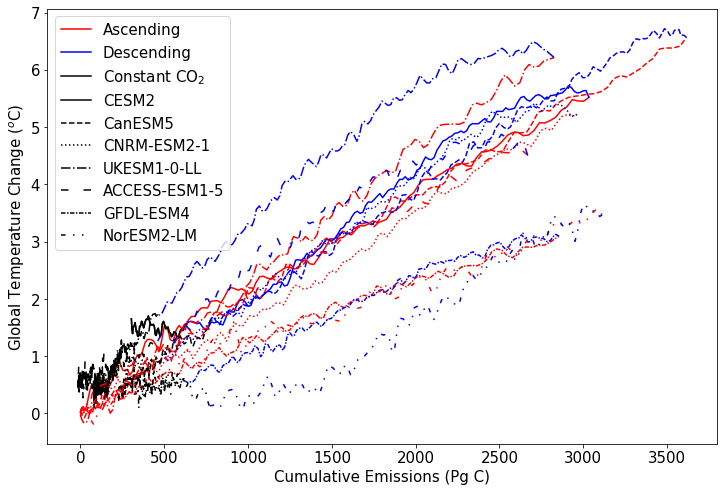

In [6]:
for model_i in range(nmodels):
    ## load the native lnd/atm map grid files
    area_file = xr.open_dataset(datadir+area_files[model_i])
    area = area_file['areacella'][:]
    lat = area_file['lat'][:]
    lon = area_file['lon'][:]

    JM = len(lat)
    IM = len(lon)

    ## load the native ocean map grid files
    area_file_ocn_gn = xr.open_dataset(datadir+area_ocn_gn_files[model_i])
    area_ocn_gn = area_file_ocn_gn['areacello'][:]
    try:
        lat_ocn_gn = area_file_ocn_gn['lat'][:]
        lon_ocn_gn = area_file_ocn_gn['lon'][:]
    except:
        lat_ocn_gn = area_file_ocn_gn['j'][:]
        lon_ocn_gn = area_file_ocn_gn['i'][:]

    JM_ocn_gn = len(lat_ocn_gn)
    IM_ocn_gn = len(lon_ocn_gn)

    ## and the land and ice grids
    sftlf_file = xr.open_dataset(datadir+sftlf_files[model_i])
    sftlf = sftlf_file['sftlf'][:]

    try:
        sftgif_file = xr.open_dataset(datadir+sftgif_files[model_i])
        sftgif = sftgif_file['sftgif'][:]
        noticefrac = (1. - sftgif_file['sftgif']/100.).fillna(0.)
    except:
        sftgif = sftlf * 0.
        noticefrac = sftgif + 1.

    area_landonly = area * (sftlf/100.) * (1. - sftgif/100.)

    landarea = (area_file['areacella'] * sftlf_file['sftlf'] / 100. * 1. )
    try:
        noticelandearea = (noticefrac.data*landarea)
    except:
        noticelandearea = (noticefrac*landarea)

    tas_1pct = xr.open_mfdataset(datadir+'tas_Amon_'+models_list[model_i]+'_1pctCO2_*.nc')
    tas_cdr = xr.open_mfdataset(datadir+'tas_Amon_'+models_list[model_i]+'_1pctCO2-cdr_*.nc')

    nbp_1pct = xr.open_mfdataset(datadir+'nbp_Lmon_'+models_list[model_i]+'_1pctCO2_*.nc')
    nbp_cdr = xr.open_mfdataset(datadir+'nbp_Lmon_'+models_list[model_i]+'_1pctCO2-cdr_*.nc')

    fgco2_1pct = xr.open_mfdataset(datadir+'fgco2_Omon_'+models_list[model_i]+'_1pctCO2_*.nc')
    fgco2_cdr = xr.open_mfdataset(datadir+'fgco2_Omon_'+models_list[model_i]+'_1pctCO2-cdr_*.nc')

    tas_1pct_annual = monthly_to_annual(tas_1pct['tas'])
    tas_cdr_annual = monthly_to_annual(tas_cdr['tas'])

    nbp_1pct_annual = monthly_to_annual(nbp_1pct['nbp'])
    nbp_cdr_annual = monthly_to_annual(nbp_cdr['nbp'])

    fgco2_1pct_annual = monthly_to_annual(fgco2_1pct['fgco2'])
    fgco2_cdr_annual = monthly_to_annual(fgco2_cdr['fgco2'])


    tas_both = xr.concat((tas_1pct_annual.isel(time=slice(None,year_4xco2)),tas_cdr_annual), dim='time')
    tas_both['time'] = np.arange(len(tas_both['time']))

    tas_globalmean = (tas_both * area).sum(dim='lat').sum(dim='lon') / (area).sum(dim='lat').sum(dim='lon')
    
    tdiff = (tas_globalmean - tas_globalmean[0])
    tdiff.attrs['long_name'] ='Global Mean Temp Change'
    tdiff.attrs['units'] ='$^o$C'
    #tdiff.plot()

    tdiff_allmodels[0:len(tdiff),model_i] = tdiff.data

    tdiff_smooth = savgol_filter(tdiff, 5)

    co2_both = tas_globalmean.copy().load()
    co2_both[0:year_4xco2] = co2_ful_global_annual[0:year_4xco2]
    co2_both[year_4xco2:year_4xco2*2] = co2_ful_global_annual[year_4xco2:0:-1]
    co2_both[year_4xco2*2:] = co2_ful_global_annual[0]

    co2_both.attrs['long_name'] ='Atmospheric CO$_2$'
    co2_both.attrs['units'] ='ppm'

    #co2_both.plot()

    dco2dt = co2_both.copy().load()
    for i in range(year_4xco2*2-1):
        dco2dt[i] = co2_both.isel(time=(i+1)) - co2_both.isel(time=(i))
    dco2dt[year_4xco2*2-1:] = 0.
    dco2dt.attrs['long_name'] ='Atmospheric CO$_2$ Growth Rate'
    dco2dt.attrs['units'] ='ppm yr$^{-1}$'

    fgco2_both = xr.concat((fgco2_1pct_annual.isel(time=slice(None,year_4xco2)),fgco2_cdr_annual), dim='time')
    fgco2_both['time'] = np.arange(len(fgco2_both['time']))

    try:
        fgco2_global = (fgco2_both * area_ocn_gn).sum(dim=['nlat','nlon']) * 86400 * 365. * 1e3 * 1e-15
    except:
        try:
            fgco2_global = (fgco2_both * area_ocn_gn).sum(dim=['i','j']) * 86400 * 365. * 1e3 * 1e-15
        except:
            try:
                fgco2_global = (fgco2_both * area_ocn_gn).sum(dim=['x','y']) * 86400 * 365. * 1e3 * 1e-15
            except:
                fgco2_global = (fgco2_both * area_ocn_gn).sum(dim=['lat','lon']) * 86400 * 365. * 1e3 * 1e-15
    fgco2_global.attrs['long_name'] ='Ocean Sink'
    fgco2_global.attrs['units'] ='Pg yr$^{-1}$'

    fgco2_allmodels[0:len(fgco2_global),model_i] = fgco2_global.data
    #fgco2_global.plot()

    nbp_both = xr.concat((nbp_1pct_annual.isel(time=slice(None,year_4xco2)),nbp_cdr_annual), dim='time')
    nbp_both['time'] = np.arange(len(nbp_both['time']))

    try:
        nbp_global = (nbp_both * noticelandearea.values).sum(dim=['lat','lon']) * 86400 * 365. * 1e3 * 1e-15
    except:
        nbp_global = (nbp_both * noticelandearea).sum(dim=['lat','lon']) * 86400 * 365. * 1e3 * 1e-15

    nbp_global.attrs['long_name'] ='Land Sink'
    nbp_global.attrs['units'] ='Pg yr$^{-1}$'

    nbp_allmodels[0:len(nbp_global),model_i] = nbp_global.data
    #nbp_global.plot()

    ppm_to_pgc = 2.124  # from le quere 2018, which gets it from ballantyne et al 2012

    cum_atm_sink = (co2_both - co2_both[0])*ppm_to_pgc
    cum_atm_sink.attrs['long_name'] ='Cumulative Atmospheric Sink'
    cum_atm_sink.attrs['units'] ='Pg C'

    cum_ocn_sink = fgco2_global.cumsum()
    cum_ocn_sink.attrs['long_name'] ='Cumulative Ocean Sink'
    cum_ocn_sink.attrs['units'] ='Pg C'

    cum_lnd_sink = nbp_global.cumsum()
    cum_lnd_sink.attrs['long_name'] ='Cumulative Land Sink'
    cum_lnd_sink.attrs['units'] ='Pg C'

    cum_emissions = cum_atm_sink + cum_lnd_sink + cum_ocn_sink
    cum_emissions.attrs['long_name'] ='Cumulative Emissions'
    cum_emissions.attrs['units'] ='Pg C'

    cum_emissions_allmodels[0:len(cum_emissions),model_i] = cum_emissions.data

    #cum_emissions.plot()
    #cum_ocn_sink.plot()
    #cum_lnd_sink.plot()
    #cum_atm_sink.plot()

    annual_emissions = dco2dt*ppm_to_pgc + fgco2_global + nbp_global
    annual_emissions.attrs['long_name'] ='Inferred Emissions'
    annual_emissions.attrs['units'] ='Pg C yr$^{-1}$'

    annual_emissions_allmodels[0:len(annual_emissions),model_i] = annual_emissions.data
    #annual_emissions.plot()

    yr_maxemiss = int(cum_emissions.argmax())

    if model_i == 0:
        plt.plot(cum_emissions[0:yr_maxemiss+1].data, (tdiff_smooth[0:yr_maxemiss+1]).data, color='red', label='Ascending', linestyle=dashpattern[model_i])
        plt.plot(cum_emissions[yr_maxemiss:yr_maxemiss*2+1].data, (tdiff_smooth[yr_maxemiss:yr_maxemiss*2+1]).data, color='blue', label='Descending', linestyle=dashpattern[model_i])
        plt.plot(cum_emissions[yr_maxemiss*2:].data, (tdiff_smooth[yr_maxemiss*2:]).data, color='black', label='Constant CO$_2$', linestyle=dashpattern[model_i])
    else:
        plt.plot(cum_emissions[0:yr_maxemiss+1].data, (tdiff_smooth[0:yr_maxemiss+1]).data, color='red', linestyle=dashpattern[model_i])
        plt.plot(cum_emissions[yr_maxemiss:yr_maxemiss*2+1].data, (tdiff_smooth[yr_maxemiss:yr_maxemiss*2+1]).data, color='blue', linestyle=dashpattern[model_i])
        
    plt.plot(cum_emissions[yr_maxemiss*2:].data, (tdiff_smooth[yr_maxemiss*2:]).data, color='black', label=models_list[model_i], linestyle=dashpattern[model_i])

plt.xlabel('Cumulative Emissions (Pg C)')
plt.ylabel('Global Temperature Change ($^{o}$C)')
plt.legend()

In [7]:
area_files[model_i]

'areacella_fx_NorESM2-LM_piControl_r1i1p1f1_gn.nc'

In [8]:
tas_globalmean

<xarray.DataArray (time: 399)>
dask.array<truediv, shape=(399,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 ... 391 392 393 394 395 396 397 398
    height   float64 2.0

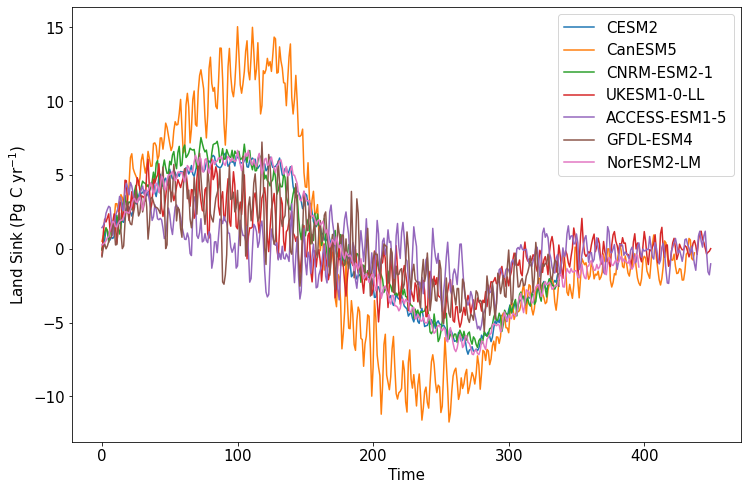

In [9]:
for model_i in range(nmodels):
    savgol_filter(nbp_allmodels.isel(model=model_i).isel(time=slice(0,450)),5,2).plot(label=models_list[model_i])
    
plt.xlabel('Time')
plt.ylabel('Land Sink (Pg C yr$^{-1}$)')
plt.legend()

In [10]:
transparency = 0.15

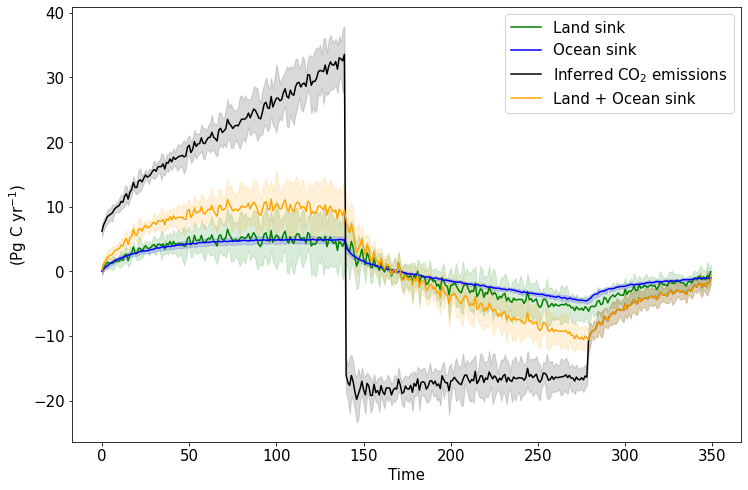

In [11]:
#savgol_filter(nbp_allmodels,5,2).isel(time=slice(0,450)).mean(dim='model').plot(color='green', label='land sink')
#plt.fill_between(np.arange(450), savgol_filter(nbp_allmodels,5,2).isel(time=slice(0,450)).mean(dim='model')+savgol_filter(nbp_allmodels,5,2).isel(time=slice(0,450)).std(dim='model'), savgol_filter(nbp_allmodels,5,2).isel(time=slice(0,450)).mean(dim='model')-savgol_filter(nbp_allmodels,5,2).isel(time=slice(0,450)).std(dim='model'), color='green', alpha=transparency)

tstop = 350

nbp_allmodels.isel(time=slice(0,tstop)).mean(dim='model').plot(color='green', label='Land sink')
plt.fill_between(np.arange(tstop), nbp_allmodels.isel(time=slice(0,tstop)).mean(dim='model')+nbp_allmodels.isel(time=slice(0,tstop)).std(dim='model'), nbp_allmodels.isel(time=slice(0,tstop)).mean(dim='model')-nbp_allmodels.isel(time=slice(0,tstop)).std(dim='model'), color='green', alpha=transparency)

fgco2_allmodels.isel(time=slice(0,tstop)).mean(dim='model').plot(color='blue', label='Ocean sink')
plt.fill_between(np.arange(tstop), fgco2_allmodels.isel(time=slice(0,tstop)).mean(dim='model')+fgco2_allmodels.isel(time=slice(0,tstop)).std(dim='model'), fgco2_allmodels.isel(time=slice(0,tstop)).mean(dim='model')-fgco2_allmodels.isel(time=slice(0,tstop)).std(dim='model'), color='blue', alpha=transparency)

annual_emissions_allmodels.isel(time=slice(0,tstop)).mean(dim='model').plot(color='black', label='Inferred CO$_2$ emissions')
plt.fill_between(np.arange(tstop), annual_emissions_allmodels.isel(time=slice(0,tstop)).mean(dim='model')+annual_emissions_allmodels.isel(time=slice(0,tstop)).std(dim='model'), annual_emissions_allmodels.isel(time=slice(0,tstop)).mean(dim='model')-annual_emissions_allmodels.isel(time=slice(0,tstop)).std(dim='model'), color='black', alpha=transparency)

combined_sink = fgco2_allmodels + nbp_allmodels
combined_sink.isel(time=slice(0,tstop)).mean(dim='model').plot(color='Orange', label='Land + Ocean sink')
plt.fill_between(np.arange(tstop), combined_sink.isel(time=slice(0,tstop)).mean(dim='model')+combined_sink.isel(time=slice(0,tstop)).std(dim='model'), combined_sink.isel(time=slice(0,tstop)).mean(dim='model')-combined_sink.isel(time=slice(0,tstop)).std(dim='model'), color='Orange', alpha=transparency)




plt.xlabel('Time')
plt.ylabel('(Pg C yr$^{-1}$)')
plt.legend()

plt.savefig('cdrmip_flux_timeseries.png', dpi=300, format='png')
plt.savefig('cdrmip_flux_timeseries.pdf')

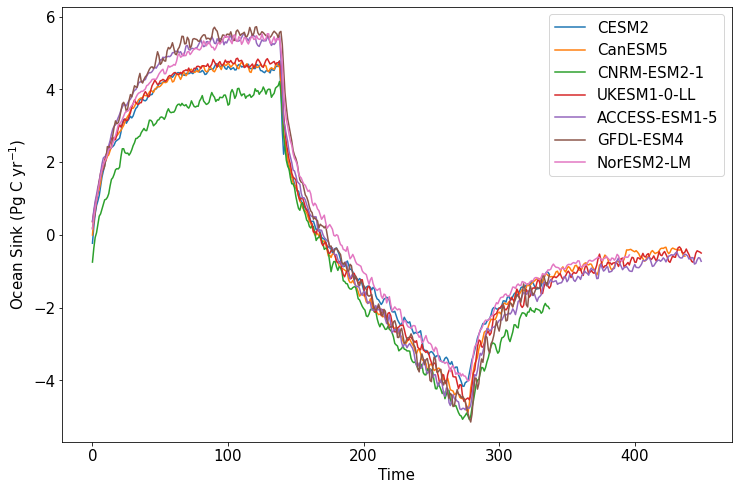

In [12]:
for model_i in range(nmodels):
    savgol_filter(fgco2_allmodels.isel(model=model_i).isel(time=slice(0,450)),5,2).plot(label=models_list[model_i])
    
plt.xlabel('Time')
plt.ylabel('Ocean Sink (Pg C yr$^{-1}$)')
plt.legend()

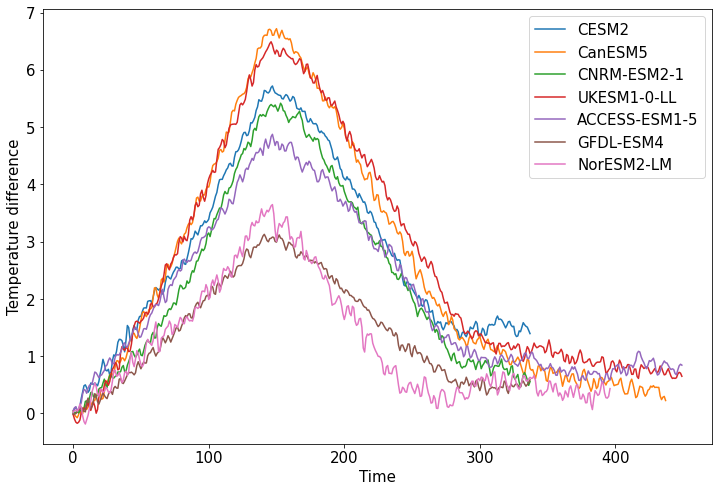

In [13]:
for model_i in range(nmodels):
    savgol_filter(tdiff_allmodels.isel(model=model_i).isel(time=slice(0,450)),5,2).plot(label=models_list[model_i])
    
plt.xlabel('Time')
plt.ylabel('Temperature difference')
plt.legend()

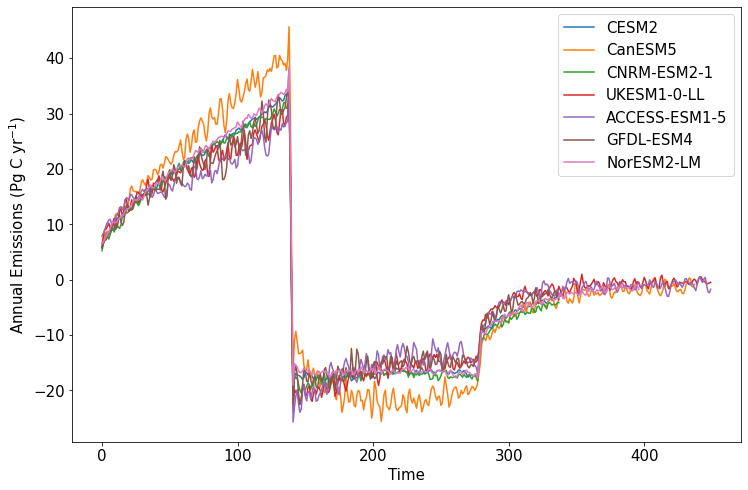

In [14]:
for model_i in range(nmodels):
    savgol_filter(annual_emissions_allmodels.isel(model=model_i).isel(time=slice(0,450)),5,2).plot(label=models_list[model_i])
    
plt.xlabel('Time')
plt.ylabel('Annual Emissions (Pg C yr$^{-1}$)')
plt.legend()

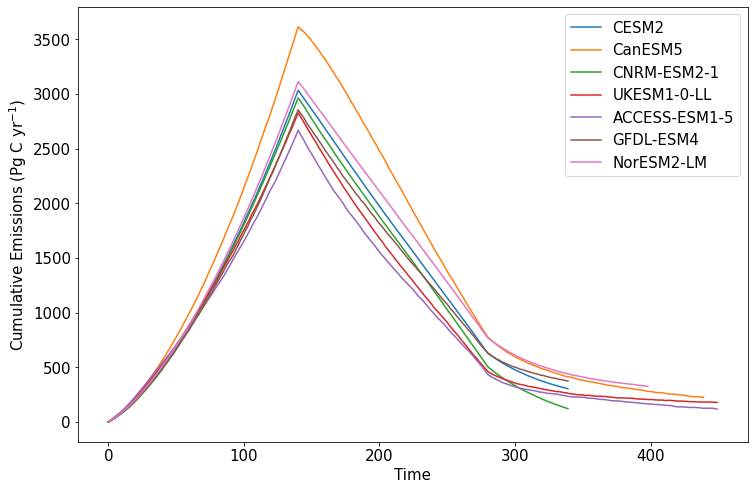

In [15]:
for model_i in range(nmodels):
    cum_emissions_allmodels.isel(model=model_i).isel(time=slice(0,450)).plot(label=models_list[model_i])
    
plt.xlabel('Time')
plt.ylabel('Cumulative Emissions (Pg C yr$^{-1}$)')
plt.legend()

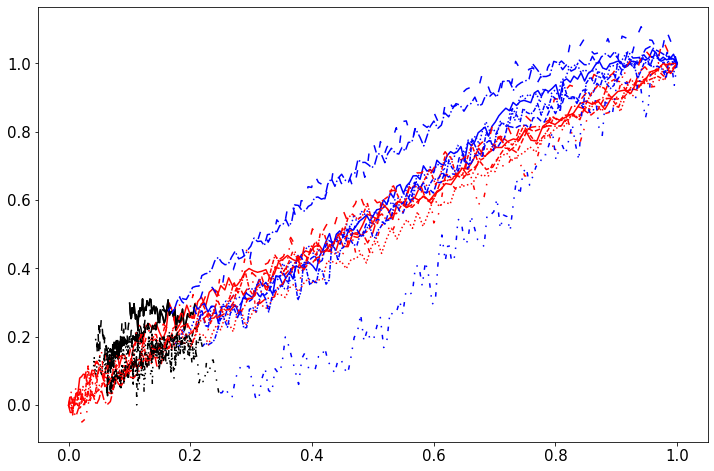

In [16]:
yr_maxemiss = 140

cum_emissions_rel = cum_emissions_allmodels.isel(time=slice(0,450)) / cum_emissions_allmodels.isel(time=yr_maxemiss)
    
#tdiff_smooth_rel = savgol_filter(tdiff_allmodels.isel(time=slice(0,450)),5,2) / savgol_filter(tdiff_allmodels.isel(time=slice(0,450)),5,2).isel(time=yr_maxemiss)
tdiff_smooth_rel = tdiff_allmodels.isel(time=slice(0,450)) / tdiff_allmodels.isel(time=yr_maxemiss)


for model_i in range(nmodels):


    if model_i == 0:
        plt.plot(cum_emissions_rel.isel(model=model_i)[0:yr_maxemiss+1].data, (tdiff_smooth_rel.isel(model=model_i)[0:yr_maxemiss+1]).data, color='red', label='Ascending', linestyle=dashpattern[model_i])
        plt.plot(cum_emissions_rel.isel(model=model_i)[yr_maxemiss:yr_maxemiss*2+1].data, (tdiff_smooth_rel.isel(model=model_i)[yr_maxemiss:yr_maxemiss*2+1]).data, color='blue', label='Descending', linestyle=dashpattern[model_i])
        plt.plot(cum_emissions_rel.isel(model=model_i)[yr_maxemiss*2:].data, (tdiff_smooth_rel.isel(model=model_i)[yr_maxemiss*2:]).data, color='black', label='Constant CO$_2$', linestyle=dashpattern[model_i])
    else:
        plt.plot(cum_emissions_rel.isel(model=model_i)[0:yr_maxemiss+1].data, (tdiff_smooth_rel.isel(model=model_i)[0:yr_maxemiss+1]).data, color='red', linestyle=dashpattern[model_i])
        plt.plot(cum_emissions_rel.isel(model=model_i)[yr_maxemiss:yr_maxemiss*2+1].data, (tdiff_smooth_rel.isel(model=model_i)[yr_maxemiss:yr_maxemiss*2+1]).data, color='blue', linestyle=dashpattern[model_i])
        
    plt.plot(cum_emissions_rel.isel(model=model_i)[yr_maxemiss*2:].data, (tdiff_smooth_rel.isel(model=model_i)[yr_maxemiss*2:]).data, color='black', label=models_list[model_i], linestyle=dashpattern[model_i])



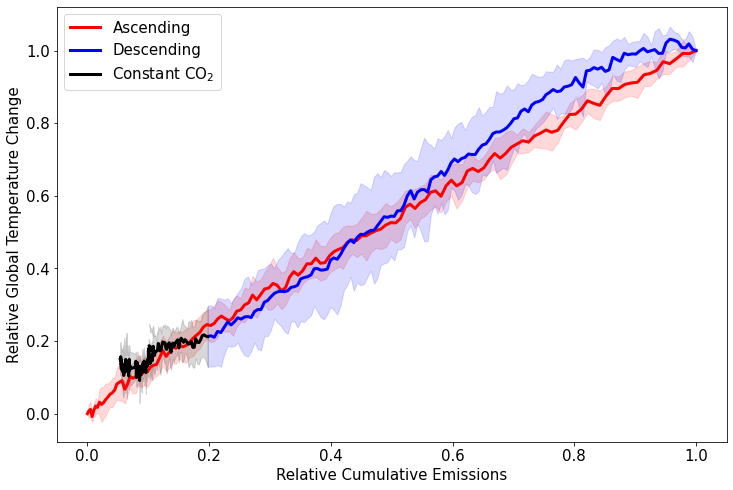

In [17]:
plt.plot(cum_emissions_rel.mean(dim='model')[0:yr_maxemiss+1].data, (tdiff_smooth_rel.mean(dim='model')[0:yr_maxemiss+1]).data, color='red', label='Ascending', linewidth=3)
plt.plot(cum_emissions_rel.mean(dim='model')[yr_maxemiss:yr_maxemiss*2+1].data, (tdiff_smooth_rel.mean(dim='model')[yr_maxemiss:yr_maxemiss*2+1]).data, color='blue', label='Descending', linewidth=3)
plt.plot(cum_emissions_rel.mean(dim='model')[yr_maxemiss*2:].data, (tdiff_smooth_rel.mean(dim='model')[yr_maxemiss*2:]).data, color='black', label='Constant CO$_2$', linewidth=3)


plt.fill_between(cum_emissions_rel.mean(dim='model')[0:yr_maxemiss+1].data, (tdiff_smooth_rel.mean(dim='model')[0:yr_maxemiss+1]).data-(tdiff_smooth_rel.std(dim='model')[0:yr_maxemiss+1]).data, (tdiff_smooth_rel.mean(dim='model')[0:yr_maxemiss+1]).data+(tdiff_smooth_rel.std(dim='model')[0:yr_maxemiss+1]).data, color='red', alpha=transparency)
plt.fill_between(cum_emissions_rel.mean(dim='model')[yr_maxemiss:yr_maxemiss*2+1].data, (tdiff_smooth_rel.mean(dim='model')[yr_maxemiss:yr_maxemiss*2+1]).data-(tdiff_smooth_rel.std(dim='model')[yr_maxemiss:yr_maxemiss*2+1]).data, (tdiff_smooth_rel.mean(dim='model')[yr_maxemiss:yr_maxemiss*2+1]).data+(tdiff_smooth_rel.std(dim='model')[yr_maxemiss:yr_maxemiss*2+1]).data, color='blue', alpha=transparency)
plt.fill_between(cum_emissions_rel.mean(dim='model')[yr_maxemiss*2:].data, (tdiff_smooth_rel.mean(dim='model')[yr_maxemiss*2:]).data-(tdiff_smooth_rel.std(dim='model')[yr_maxemiss*2:]).data, (tdiff_smooth_rel.mean(dim='model')[yr_maxemiss*2:]).data+(tdiff_smooth_rel.std(dim='model')[yr_maxemiss*2:]).data, color='black', alpha=transparency)



plt.xlabel('Relative Cumulative Emissions')
plt.ylabel('Relative Global Temperature Change')
plt.legend()

plt.savefig('cdrmip_t_ce.png', dpi=300, format='png')
plt.savefig('cdrmip_t_ce.pdf')